Creating Models on this Jupyter Notebook


# Data Gathering


In [7]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests

# To unzip the edf_dataset
import zipfile
import os

# EDFlib and Data Preprocesing module
from mne.preprocessing import ICA, create_eog_epochs
import mne
from pyedflib import highlevel
import pyedflib as plib

In [8]:
import requests


def download_file(url, save_path):

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File already exists at '{save_path}'. Skipping download.")
        return  # Exit the function if the file exists

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in binary write mode and save the content
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved to '{save_path}'")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


# Specify the URL and the path where you want to save the file
url = 'https://figshare.com/ndownloader/articles/4244171/versions/2'
# Change this to your desired path
save_path = './edf_dataset.zip'

# Call the function to download the file
download_file(url, save_path)

File already exists at './edf_dataset.zip'. Skipping download.


In [9]:
def unzip_file(zip_file_path, extract_to_folder):

    # Check if the directory exist
    
    if os.path.exists(extract_to_folder):
        print(f"Directory '{extract_to_folder} already exists")
        return # Exit the function if the directory
    
    # Create the directory if it doesn't exist
    os.makedirs(extract_to_folder, exist_ok=True)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(extract_to_folder)


# Specify the path to the zip file and the extraction folder
zip_file_path = './edf_dataset.zip'
# Change this if needed
extract_to_folder = './edf_dataset_2'

# Call the function to unzip
unzip_file(zip_file_path, extract_to_folder)


Directory './edf_dataset_2 already exists


In [10]:
import os
import re

edf_directory = "./edf_dataset_2"

for filename in os.listdir(edf_directory):
    new_filename = filename
    
    # Handle spaces in filename
    if ' ' in new_filename:
        new_filename = re.sub(r'\s+', '_', new_filename)
    
    # Handle subject numbers (S1 -> S01)
    new_filename = re.sub(r'S(\d)(?!\d)', r'S0\1', new_filename)
    
    # Handle filenames containing '6931959'
    if '6931959' in new_filename:
        new_filename = new_filename.replace('6931959_', '')
    
    # Handle filenames containing '6921143'
    if '6921143' in new_filename:
        new_filename = new_filename.replace('6921143_', '')
    
    # Zero-pad other single-digit numbers in filenames
    new_filename = re.sub(r'(?<!\d)(\d)(?!\d)', r'0\1', new_filename)
    
    # Only rename if the filename has changed
    if new_filename != filename:
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)
        
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')

print("Renaming complete.")

Renaming complete.


# Preprocessing Functions


In [11]:
import pandas as pd

# Load demographic data
demographics_df = pd.read_csv('./input/demographics.csv')

# Display initial information about the data
print("Initial demographic data shape:", demographics_df.shape)
print("\nFirst few rows:")
print(demographics_df.head())
print("\nData info:")
print(demographics_df.info())
print("\nMissing values:")
print(demographics_df.isnull().sum())

Initial demographic data shape: (67, 4)

First few rows:
  Sample Gender Age   Health
0   HS01      M  24  Healthy
1   HS02      M  19  Healthy
2   HS03      M  21  Healthy
3   HS04      M  35  Healthy
4   HS05      F  26  Healthy

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sample  67 non-null     object
 1   Gender  67 non-null     object
 2   Age     67 non-null     object
 3   Health  67 non-null     object
dtypes: object(4)
memory usage: 2.2+ KB
None

Missing values:
Sample    0
Gender    0
Age       0
Health    0
dtype: int64


In [12]:
# Clean and preprocess demographic data
def clean_demographics(df):
    # Create a copy to avoid modifying original data
    df_clean = df.copy()

    # Convert Gender to numeric (M=0, F=1)
    df_clean['Gender'] = df_clean['Gender'].map(
        {'M': 0, 'F': 1, 'Error': None})

    # Clean Age column
    df_clean['Age'] = pd.to_numeric(
        df_clean['Age'], errors='coerce')  # Convert 'Error' to NaN

    # Convert Health to numeric (Healthy=0, MDD=1)
    df_clean['Health'] = df_clean['Health'].map({'Healthy': 0, 'MDD': 1})

    # Create subject ID from Sample column (extract number only)
    df_clean['Subject_ID'] = df_clean['Sample'].str.extract(
        '(\d+)').astype(int)

    # Remove rows with missing values
    df_clean = df_clean.dropna()

    print("Cleaned demographic data summary:")
    print(f"Total samples: {len(df_clean)}")
    print(f"Gender distribution:\n{df_clean['Gender'].value_counts()}")
    print(f"\nAge statistics:\n{df_clean['Age'].describe()}")
    print(f"\nHealth distribution:\n{df_clean['Health'].value_counts()}")

    return df_clean


# Apply cleaning
demographics_clean = clean_demographics(demographics_df)

Cleaned demographic data summary:
Total samples: 64
Gender distribution:
Gender
0.0    38
1.0    26
Name: count, dtype: int64

Age statistics:
count    64.000000
mean     34.484375
std      16.030717
min      12.000000
25%      21.000000
50%      33.000000
75%      48.000000
max      76.000000
Name: Age, dtype: float64

Health distribution:
Health
1    33
0    31
Name: count, dtype: int64


In [13]:
# Function to rename channels and drop specified channels based on conditions
def process_channels(raw_data):
    """
    Process and standardize EEG channels to keep only the 17 most common channels.
    """
    print(f"Initial channels: {raw_data.ch_names}")

    # Initialize a list to hold channels to drop
    channels_to_drop = []

    # Create mapping for channel renaming
    rename_map = {}
    for name in raw_data.ch_names:
        if any(x in name for x in ['23A-23R', '24A-24R', 'A2-A1']):
            channels_to_drop.append(name)
        else:
            new_name = name.replace('EEG ', '').replace('-LE', '')
            rename_map[name] = new_name

    # Drop unwanted channels
    if channels_to_drop:
        print(f"Dropping channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Rename remaining channels
    raw_data.rename_channels(rename_map)

    print(f"Final channels: {raw_data.ch_names}")

    # Define the 17 most common channels
    expected_channels = [
        'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
        'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
    ]

    # Keep only the expected channels
    channels_to_keep = set(expected_channels)
    channels_to_drop = [
        ch for ch in raw_data.ch_names if ch not in channels_to_keep]

    if channels_to_drop:
        print(
            f"Dropping channels to keep only the expected 17 channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Verify we have the expected number of channels (should be 17)
    if len(raw_data.ch_names) != len(expected_channels):
        print(
            f"Warning: Expected {len(expected_channels)} channels, got {len(raw_data.ch_names)}")
        print(f"Missing: {set(expected_channels) - set(raw_data.ch_names)}")

    return raw_data

In [14]:
all_edf_files = os.listdir(edf_directory)
ec_file_path = [i for i in all_edf_files if i.endswith('EC.edf')]
eo_file_path = [i for i in all_edf_files if i.endswith('EO.edf')]
task_file_path = [i for i in all_edf_files if i.endswith('TASK.edf')]

print(len(all_edf_files), len(ec_file_path), len(eo_file_path), len(task_file_path))

180 58 61 61


In [15]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    return data
    

In [16]:
def bandpass_filter(data, l_freq, h_freq):
    # Adjust the filter parameters as needed
    data.filter(l_freq=l_freq, h_freq=h_freq)

In [17]:
def preprocess_ICA(raw, n_components ):
    print(f"Preprocessing ICA: {raw.filenames}")

    ica = ICA(n_components=n_components,random_state=97,
              max_iter=800) 
    ica.fit(raw)
    return ica

In [18]:
# Directory containing the EDF files
edf_directory = "./edf_dataset_2"  # Adjust this path to your dataset location

# Initialize lists
processed_raw_data = []
class_counts = {'Healthy': 0, 'MDD': 0}

# Read all EDF files
for filename in os.listdir(edf_directory):
    if filename.endswith('.edf'):
        file_path = os.path.join(edf_directory, filename)
        try:
            # Read the raw data
            raw_data = read_data(file_path)

            if raw_data is not None:
                processed_raw_data.append(raw_data)
                print(f"Successfully loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

print(f"\nTotal files loaded: {len(processed_raw_data)}")

Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S01_EC.edf
Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 89855  =      0.000 ...   350.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S01_EO.edf
Extracting EDF parameters from c:\Capstone\depression-detection-eeg-python\edf_dataset_2\H_S01_TASK.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154879  =      0.0

# Actual Preprocessing Function


In [19]:
def preprocess_eeg(raw_data, l_freq=0.5, h_freq=50.0, n_components=5, time_steps=5, samples_per_step=256):
    """
    Complete EEG preprocessing pipeline: bandpass -> ICA -> reshape for CNN-LSTM
    """
    try:
        print(f"\nProcessing file: {raw_data.filenames}")
        
        processed_raw = process_channels(raw_data=raw_data)

        # 1. Bandpass filtering
        print("1. Applying bandpass filter...")
        bandpass_filter(processed_raw, l_freq, h_freq)

        # 2. ICA
        print("2. Applying ICA...")
        ica = preprocess_ICA(processed_raw, n_components)
        ica.apply(processed_raw)
        
         # 3. Normalization (Z-score normalization per channel)
        print("3. Normalizing data...")
        # Extract the data array from the processed_raw object
        # Shape: (n_channels, n_samples)
        data = processed_raw.get_data()
        # Use Z-score normalization: subtract channel-wise mean and divide by channel-wise std dev
        epsilon = 1e-10  # small constant to prevent division by zero
        data = (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + epsilon)

        # 4. Reshape data for CNN-LSTM
        print("4. Reshaping data for CNN-LSTM...")
        data = processed_raw.get_data()
        n_channels = data.shape[0]
        
        # Calculate total samples needed for each complete sequence
        total_samples_per_sequence = time_steps * samples_per_step
        
        # Determine how many complete sequences we can make
        n_sequences = data.shape[1] // total_samples_per_sequence
        
        # Reshape the data
        reshaped_data = []
        for i in range(n_sequences):
            start = i * total_samples_per_sequence
            end = start + total_samples_per_sequence
            sequence = data[:, start:end]
            
            # Reshape into (time_steps, channels, samples_per_step)
            sequence = sequence.reshape(time_steps, n_channels, samples_per_step)
            
            # Transpose to (time_steps, channels, samples_per_step)
            sequence = np.transpose(sequence, (0, 2, 1))
            
            reshaped_data.append(sequence)
        
        # Convert to numpy array and add channel dimension
        final_data = np.array(reshaped_data)[..., np.newaxis]
        
        print(f"Reshaping completed. Final data shape: {final_data.shape}")
        return final_data

    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        return None


# Actual Preprocessing


In [20]:
def integrate_demographics_with_eeg(raw_data, demographics_clean):
    X_data = []
    y_labels = []
    demographic_features = []  # Will store age and gender for each epoch
    class_counts = {'Healthy': 0, 'MDD': 0}

    for raw_data in processed_raw_data:
        filename = os.path.basename(raw_data.filenames[0])

        # Extract subject number from filename (S34 from MDD_S34_EC.edf)
        subject_id = int(re.search(r'S(\d+)', filename).group(1))

        # Get demographic data for this subject
        subject_demographics = demographics_clean[demographics_clean['Subject_ID'] == subject_id]

        if len(subject_demographics) == 0:
            print(f"No demographic data found for subject {subject_id}")
            continue

        # Process EEG data as before
        processed_data = preprocess_eeg(raw_data, l_freq=0.5, h_freq=50.0,
                                        n_components=5, time_steps=5, samples_per_step=256)

        if processed_data is not None:
            X_data.append(processed_data)

            # Create label (1 for MDD, 0 for Healthy)
            label = 1 if filename.startswith('MDD') else 0
            y_labels.extend([label] * processed_data.shape[0])

            # Add demographic features for each epoch
            age = subject_demographics['Age'].values[0]
            gender = subject_demographics['Gender'].values[0]
            demographic_features.extend(
                [[age, gender]] * processed_data.shape[0])

            # Update counts
            if label == 1:
                class_counts['MDD'] += processed_data.shape[0]
            else:
                class_counts['Healthy'] += processed_data.shape[0]

    return X_data, y_labels, demographic_features, class_counts

In [21]:
# First load your demographic data
demographics_df = pd.read_csv('./input/demographics.csv')
demographics_clean = clean_demographics(demographics_df)

# Replace your existing preprocessing loop with the integrated version
X_data, y_labels, demographic_features, class_counts = integrate_demographics_with_eeg(
    processed_raw_data,  # Your raw EEG data
    demographics_clean   # Your cleaned demographic data
)

# Print summary to verify integration
print("\nIntegration Summary:")
print(f"Total samples processed: {len(X_data)}")
print(f"Number of labels: {len(y_labels)}")
print(f"Number of demographic features: {len(demographic_features)}")
print(f"Class distribution: {class_counts}")

Cleaned demographic data summary:
Total samples: 64
Gender distribution:
Gender
0.0    38
1.0    26
Name: count, dtype: int64

Age statistics:
count    64.000000
mean     34.484375
std      16.030717
min      12.000000
25%      21.000000
50%      33.000000
75%      48.000000
max      76.000000
Name: Age, dtype: float64

Health distribution:
Health
1    33
0    31
Name: count, dtype: int64

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S01_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dro

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

2. Applying ICA...
Preprocessing ICA: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S01_EC.edf',)
Fitting ICA to data using 17 channels (please be patient, this may take a while)


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S01_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (70, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S01_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S02_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S02_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S02_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S03_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S03_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S03_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S04_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S04_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S04_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 c

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S05_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S05_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (62, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S05_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S06_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S06_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S06_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S07_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (71, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S07_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S07_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S08_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S08_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S08_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 11.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S09_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S09_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S09_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (120, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S10_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (75, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S10_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S10_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S11_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S11_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S11_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S12_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S12_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S13_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S13_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S13_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S14_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S14_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (38, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S14_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 28.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S15_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S15_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S15_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S16_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 conti

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (58, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S16_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S16_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S17_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S17_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S17_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S18_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S18_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 36.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S19_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S19_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S19_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S20_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S20_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (64, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S21_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S21_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 5.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S22_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S22_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S22_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (120, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S23_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S23_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S23_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 37.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (124, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S24_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 cont

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

2. Applying ICA...
Preprocessing ICA: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S24_EC.edf',)
Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S24_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5',

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S24_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S25_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 conti

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S25_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S26_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 16.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S26_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fil

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S26_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S27_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 conti

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S27_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S27_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S28_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S28_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S28_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S29_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S29_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filt

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S29_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S30_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 conti

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S30_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass 

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\H_S30_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S01_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S01_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S01_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S02_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S02_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S02_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S03_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (36, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S03_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S03_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S04_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S04_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S05_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz'

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S05_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S05_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S06_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S06_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S06_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S07_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S07_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S08_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'F

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (121, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S09_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S09_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S10_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S10_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S10_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (137, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S11_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S11_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S11_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S12_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (37, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S12_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (129, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S13_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S13_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (62, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S13_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S14_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S14_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S14_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S15_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S15_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S15_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S16_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S16_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S17_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S17_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S17_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S18_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S18_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S18_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S19_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S19_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S19_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S20_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S20_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S20_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S21_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S21_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S21_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S22_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S22_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S22_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (128, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S23_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S23_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (61, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S23_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S24_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S24_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S24_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S25_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S25_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S25_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S26_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S26_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S26_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (127, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S27_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S27_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Fi

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S27_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (122, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S28_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S28_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S28_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S29_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S29_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S29_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S30_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (48, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S30_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S30_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S31_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S31_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S31_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (126, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S32_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S32_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (60, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S32_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (125, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S33_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S33_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S33_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (131, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S34_EC.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 con

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S34_EO.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pas

c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (59, 5, 256, 17, 1)

Processing file: ('c:\\Capstone\\depression-detection-eeg-python\\edf_dataset_2\\MDD_S34_TASK.edf',)
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
1. Applying bandpass filter...


c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1008: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Capstone\depression-detection-eeg-python\capstone_env\Lib\site-packages\mne\filter.py:1724: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele

Selecting by number: 5 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 17 PCA components
3. Normalizing data...
4. Reshaping data for CNN-LSTM...
Reshaping completed. Final data shape: (131, 5, 256, 17, 1)

Integration Summary:
Total samples processed: 180
Number of labels: 14683
Number of demographic features: 14683
Class distribution: {'Healthy': 6860, 'MDD': 7823}


In [22]:
if len(X_data) > 0:
    try:
        # Print shapes before concatenation
        print("\nArray shapes before concatenation:")
        for i, arr in enumerate(X_data):
            print(f"Array {i}: shape {arr.shape}")

        # Concatenate data
        X = np.concatenate(X_data, axis=0)
        y = np.array(y_labels)
        # Convert demographic features to numpy array
        demographics = np.array(demographic_features)

        # Print final information
        print("\nFinal Dataset Information:")
        print(f"Total samples: {len(X)}")
        print(f"Healthy samples: {class_counts['Healthy']}")
        print(f"MDD samples: {class_counts['MDD']}")
        print(f"Input shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Demographics shape: {demographics.shape}")

        # Print demographic statistics
        print("\nDemographic Statistics:")
        print(f"Average age: {demographics[:, 0].mean():.2f}")
        print(
            f"Gender distribution (0=M, 1=F): {np.bincount(demographics[:, 1].astype(int))}")

    except Exception as e:
        print(f"\nError during final processing: {str(e)}")
        print("Checking individual arrays for inconsistencies...")
        base_shape = X_data[0].shape[1:]
        for i, arr in enumerate(X_data):
            if arr.shape[1:] != base_shape:
                print(
                    f"Mismatch at index {i}: expected {base_shape}, got {arr.shape[1:]}")
else:
    print("\nNo data was successfully processed!")


Array shapes before concatenation:
Array 0: shape (60, 5, 256, 17, 1)
Array 1: shape (70, 5, 256, 17, 1)
Array 2: shape (121, 5, 256, 17, 1)
Array 3: shape (60, 5, 256, 17, 1)
Array 4: shape (60, 5, 256, 17, 1)
Array 5: shape (121, 5, 256, 17, 1)
Array 6: shape (60, 5, 256, 17, 1)
Array 7: shape (61, 5, 256, 17, 1)
Array 8: shape (121, 5, 256, 17, 1)
Array 9: shape (60, 5, 256, 17, 1)
Array 10: shape (59, 5, 256, 17, 1)
Array 11: shape (121, 5, 256, 17, 1)
Array 12: shape (60, 5, 256, 17, 1)
Array 13: shape (62, 5, 256, 17, 1)
Array 14: shape (122, 5, 256, 17, 1)
Array 15: shape (60, 5, 256, 17, 1)
Array 16: shape (60, 5, 256, 17, 1)
Array 17: shape (122, 5, 256, 17, 1)
Array 18: shape (71, 5, 256, 17, 1)
Array 19: shape (60, 5, 256, 17, 1)
Array 20: shape (121, 5, 256, 17, 1)
Array 21: shape (60, 5, 256, 17, 1)
Array 22: shape (60, 5, 256, 17, 1)
Array 23: shape (121, 5, 256, 17, 1)
Array 24: shape (60, 5, 256, 17, 1)
Array 25: shape (60, 5, 256, 17, 1)
Array 26: shape (120, 5, 256, 

In [23]:
print(X_data[:100])

[array([[[[[-3.35208969e-21],
          [ 1.22749418e-06],
          [-1.52363265e-05],
          ...,
          [ 6.58702605e-06],
          [-2.95440172e-21],
          [-1.06059016e-06]],

         [[ 1.16807303e-06],
          [ 1.24379870e-06],
          [-1.66858678e-05],
          ...,
          [ 6.14681396e-06],
          [-2.66370371e-06],
          [-3.62216930e-06]],

         [[ 1.70816411e-06],
          [ 2.09327067e-06],
          [-1.72230198e-05],
          ...,
          [ 5.50142014e-06],
          [-4.42784883e-06],
          [-6.25091366e-06]],

         ...,

         [[ 7.02380474e-06],
          [-1.96567793e-05],
          [ 3.79006526e-06],
          ...,
          [ 7.38602801e-07],
          [-3.13286983e-06],
          [ 9.03505130e-06]],

         [[ 2.56541982e-06],
          [-1.63019359e-05],
          [ 5.27456720e-06],
          ...,
          [ 1.00649509e-06],
          [-4.23017220e-07],
          [ 6.55805063e-06]],

         [[ 1.13752753e-06],


In [24]:
print(y_labels[:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
print(demographics[:100])

[[24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]
 [24.  0.]

# Model Definition


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, LSTM, Dropout, Flatten, Reshape, TimeDistributed


def create_2dcnn_lstm_model_with_demographics(input_shape=(5, 256, 17, 1), demographic_shape=(2,)):
    # EEG input branch
    eeg_input = Input(shape=input_shape, name='eeg_input')

    # Demographic input branch
    demographic_input = Input(shape=demographic_shape,
                              name='demographic_input')

    # EEG processing branch
    x = TimeDistributed(
        Conv2D(64, (3, 3), activation='relu', padding='same'))(eeg_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(
        Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(
        Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    # Flatten CNN output while preserving time steps
    x = TimeDistributed(Flatten())(x)

    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)

    # Demographic processing branch
    demographic_features = Dense(32, activation='relu')(demographic_input)
    demographic_features = Dense(16, activation='relu')(demographic_features)

    # Combine EEG features with demographic features
    combined = tf.keras.layers.Concatenate()([x, demographic_features])

    # Dense layers for final classification
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model with multiple inputs
    model = Model(inputs=[eeg_input, demographic_input], outputs=outputs)

    return model

# Train Test Split


In [27]:
from sklearn.model_selection import train_test_split


def prepare_data_with_demographics(X_data, y_labels, demographics):
    # Combine all data
    X = np.concatenate(X_data, axis=0)
    y = np.array(y_labels)
    demographics = np.array(demographics)

    # Normalize the EEG data
    X = (X - X.mean()) / X.std()

    # Normalize demographic features (age and gender)
    demographics[:, 0] = (demographics[:, 0] - demographics[:,
                          0].mean()) / demographics[:, 0].std()  # Age normalization

    # Train-test split
    X_train, X_test, y_train, y_test, demo_train, demo_test = train_test_split(
        X, y, demographics, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, demo_train, demo_test

In [28]:
def train_model_with_demographics(model, X_train, demo_train, y_train, X_test, demo_test, y_test):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
    ]

    # Train model with multiple inputs
    history = model.fit(
        {'eeg_input': X_train, 'demographic_input': demo_train},
        y_train,
        validation_data=(
            {'eeg_input': X_test, 'demographic_input': demo_test}, y_test),
        epochs=25,
        batch_size=32,
        callbacks=callbacks
    )

    return history

# Model Evaluation


In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


def evaluate_model_with_demographics(model, X_train, demo_train, y_train, X_test, demo_test, y_test):
    # Training predictions
    y_train_pred = model.predict({
        'eeg_input': X_train,
        'demographic_input': demo_train
    })
    y_train_pred_classes = (y_train_pred > 0.5).astype(int)

    # Test predictions
    y_test_pred = model.predict({
        'eeg_input': X_test,
        'demographic_input': demo_test
    })
    y_test_pred_classes = (y_test_pred > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred_classes),
            'precision': precision_score(y_train, y_train_pred_classes),
            'recall': recall_score(y_train, y_train_pred_classes),
            'f1': f1_score(y_train, y_train_pred_classes),
            'auc': roc_auc_score(y_train, y_train_pred)
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred_classes),
            'precision': precision_score(y_test, y_test_pred_classes),
            'recall': recall_score(y_test, y_test_pred_classes),
            'f1': f1_score(y_test, y_test_pred_classes),
            'auc': roc_auc_score(y_test, y_test_pred)
        }
    }

    # Print results
    for dataset in ['train', 'test']:
        print(f"\n{dataset.capitalize()} Results:")
        for metric, value in metrics[dataset].items():
            print(f"{metric.capitalize()}: {value:.4f}")

    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Training confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred_classes)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=ax1)
    ax1.set_title('Training Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Testing confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred_classes)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Testing Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    return metrics

Epoch 1/25
368/368 [==============================] - 363s 973ms/step - loss: 0.4472 - accuracy: 0.7888 - auc: 0.8650 - val_loss: 0.2270 - val_accuracy: 0.9023 - val_auc: 0.9723 - lr: 0.0010
Epoch 2/25
368/368 [==============================] - 349s 949ms/step - loss: 0.1651 - accuracy: 0.9323 - auc: 0.9829 - val_loss: 0.1310 - val_accuracy: 0.9435 - val_auc: 0.9925 - lr: 0.0010
Epoch 3/25
368/368 [==============================] - 351s 955ms/step - loss: 0.0808 - accuracy: 0.9704 - auc: 0.9955 - val_loss: 0.1135 - val_accuracy: 0.9636 - val_auc: 0.9927 - lr: 0.0010
Epoch 4/25
368/368 [==============================] - 350s 950ms/step - loss: 0.0484 - accuracy: 0.9838 - auc: 0.9978 - val_loss: 0.0714 - val_accuracy: 0.9779 - val_auc: 0.9966 - lr: 0.0010
Epoch 5/25
368/368 [==============================] - 350s 952ms/step - loss: 0.0368 - accuracy: 0.9897 - auc: 0.9982 - val_loss: 0.0445 - val_accuracy: 0.9850 - val_auc: 0.9982 - lr: 0.0010
Epoch 6/25
368/368 [=========================

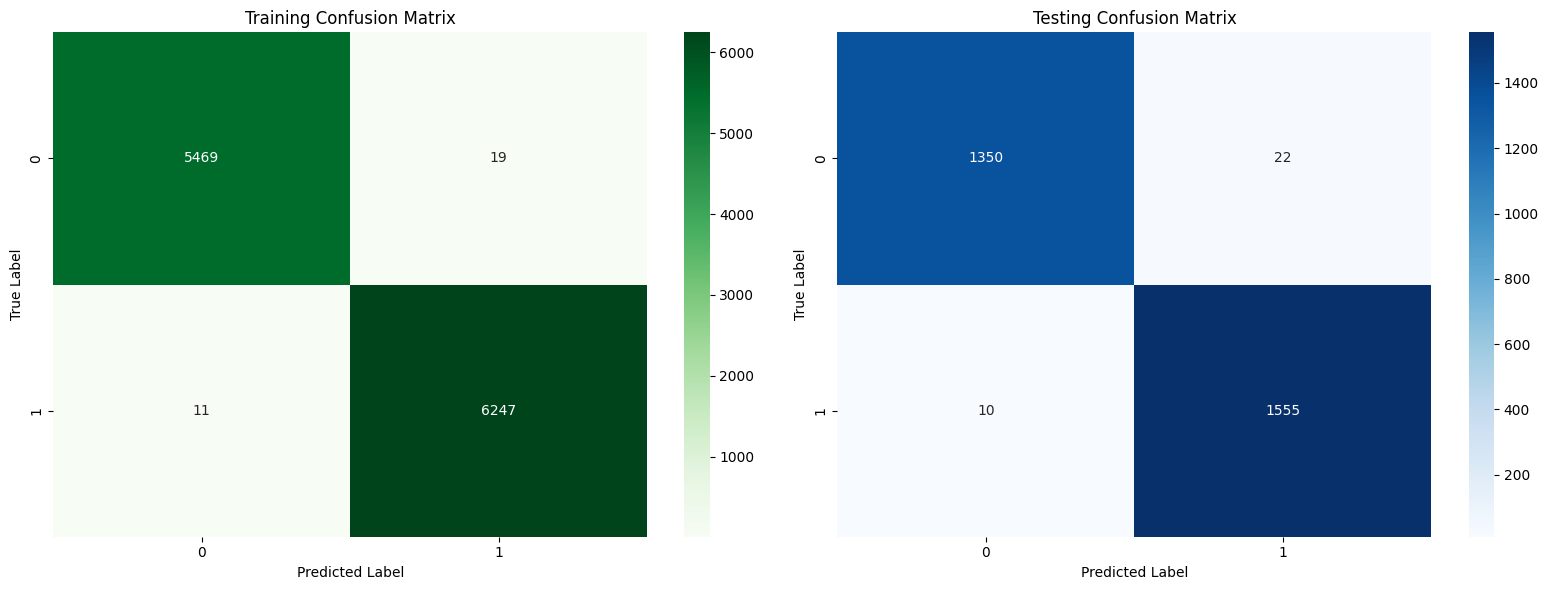

In [30]:
# First prepare the data
X_train, X_test, y_train, y_test, demo_train, demo_test = prepare_data_with_demographics(
    X_data, y_labels, demographic_features
)

# Create the model
input_shape = (5, 256, 17, 1)
demographic_shape = (2,)  # Age and Gender
model = create_2dcnn_lstm_model_with_demographics(
    input_shape, demographic_shape)

# Train the model
history = train_model_with_demographics(
    model,
    X_train, demo_train, y_train,
    X_test, demo_test, y_test
)

# Evaluate the model
metrics = evaluate_model_with_demographics(
    model,
    X_train, demo_train, y_train,
    X_test, demo_test, y_test
)

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def plot_training_history_with_demographics(history, y_test, X_test, demo_test, model):
    # Get predictions for ROC curve
    y_pred = model.predict({
        'eeg_input': X_test,
        'demographic_input': demo_test
    })

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'r--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)

    # Plot 2: Accuracy
    axes[1].plot(history.history['accuracy'], 'b-', label='Training')
    axes[1].plot(history.history['val_accuracy'], 'r-', label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Plot 3: Loss
    axes[2].plot(history.history['loss'], 'b-', label='Training')
    axes[2].plot(history.history['val_loss'], 'r-', label='Validation')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Model Loss')
    axes[2].legend(loc='upper right')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [1]:
plot_training_history_with_demographics(
    history, y_test, X_test, demo_test, model)

NameError: name 'plot_training_history_with_demographics' is not defined